Import Libraries

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from collections import Counter
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import cv2  # OpenCV for the HOG descriptor
from PIL import Image, ExifTags

from tabulate import tabulate

# Import dataset & EDA

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/54303 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.1QUN2E_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


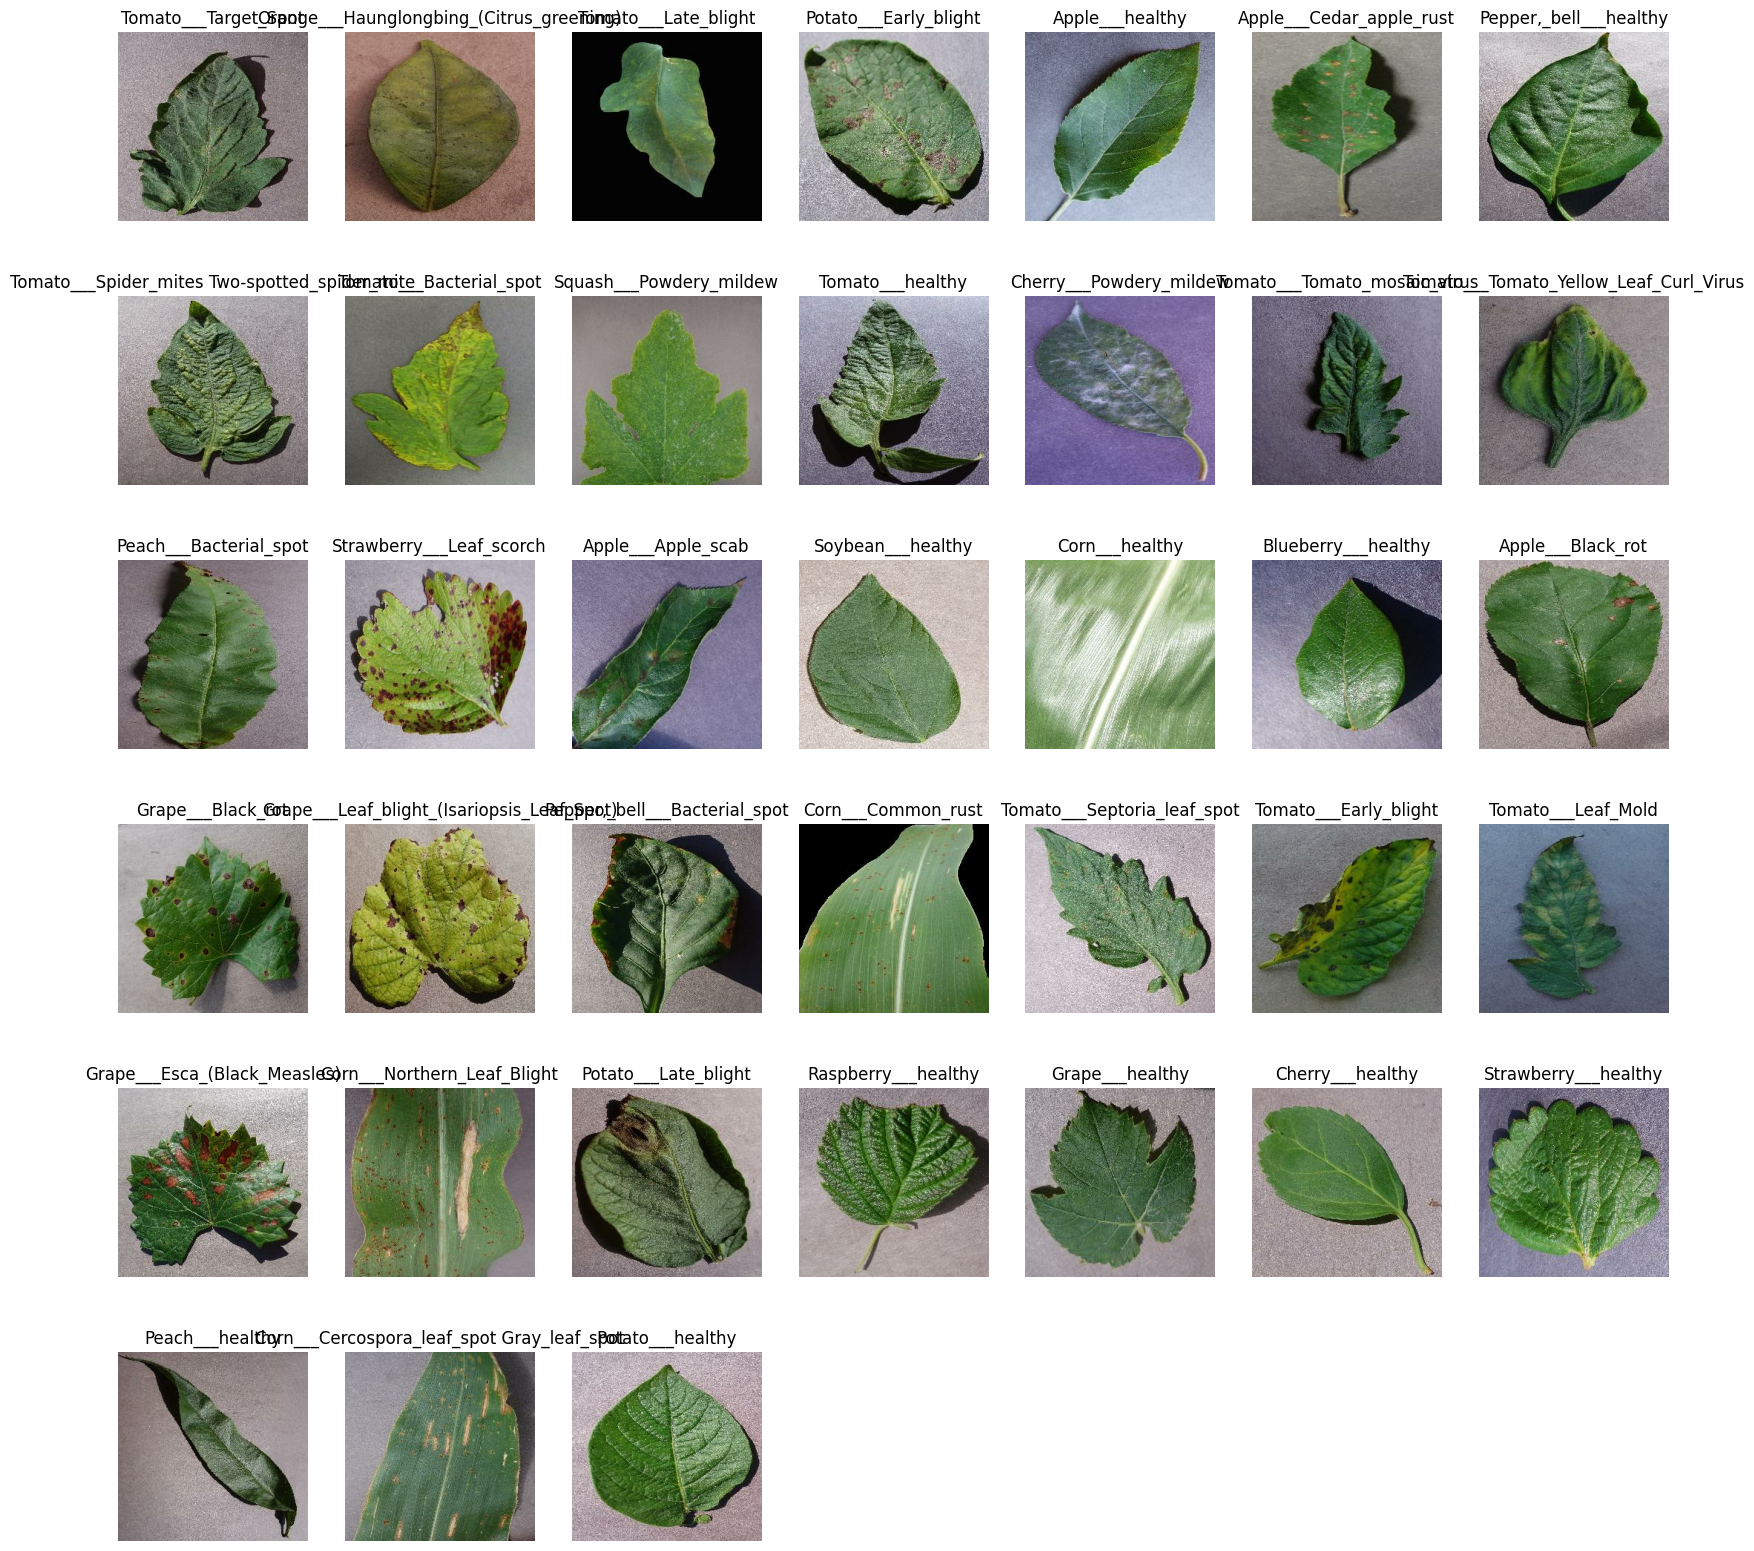

In [2]:
## Image for all categories

# Load the PlantVillage dataset
dataset, info = tfds.load('plant_village', with_info=True, as_supervised=True)

# Extract the dataset
dataset = dataset['train']

# Function to preprocess images
def preprocess(image, label):
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize the pixel values
    return image, label

# Apply preprocessing to the dataset
dataset = dataset.map(preprocess)

# Get one example per class
unique_labels = set()
samples = []

for image, label in dataset:
    label_str = info.features['label'].int2str(label.numpy())
    if label_str not in unique_labels:
        unique_labels.add(label_str)
        samples.append((image, label_str))
    if len(unique_labels) == info.features['label'].num_classes:
        break

# Display images for all categories
num_classes = len(samples)
plt.figure(figsize=(20, 20))
for i, (image, label) in enumerate(samples):
    ax = plt.subplot(6, 7, i + 1)  # Adjust the grid size if needed
    plt.imshow(image.numpy())
    plt.title(label)
    plt.axis('off')
plt.show()


Dataset Summary

Total number of images: 54303
Total number of categories: 38

Class distribution:

                                            Class  Count
0                            Tomato___Target_Spot   1404
1        Orange___Haunglongbing_(Citrus_greening)   5507
2                            Tomato___Late_blight   1908
3                           Potato___Early_blight   1000
4                                 Apple___healthy   1645
5                        Apple___Cedar_apple_rust    275
6                          Pepper,_bell___healthy   1477
7   Tomato___Spider_mites Two-spotted_spider_mite   1676
8                         Tomato___Bacterial_spot   2127
9                         Squash___Powdery_mildew   1835
10                               Tomato___healthy   1591
11                        Cherry___Powdery_mildew   1052
12                   Tomato___Tomato_mosaic_virus    373
13         Tomato___Tomato_Yellow_Leaf_Curl_Virus   5357
14                         Peach___Bacterial_spot   2297
15   

<Figure size 1200x800 with 0 Axes>

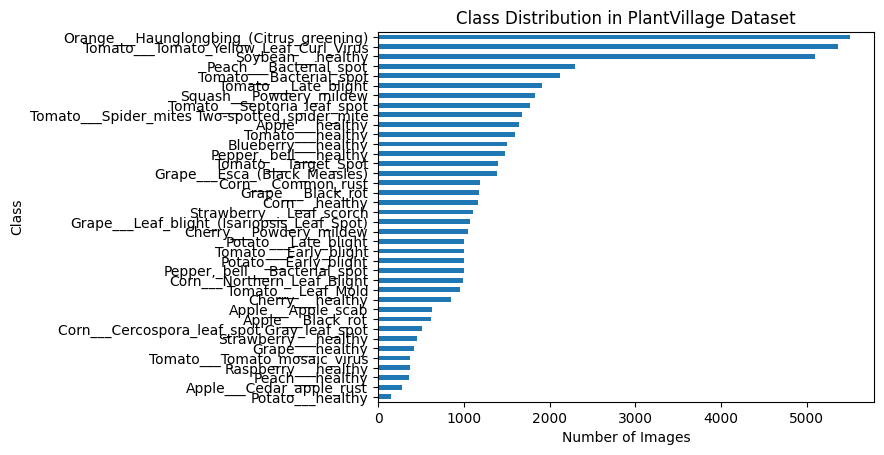

In [3]:
# Load the PlantVillage dataset
dataset, info = tfds.load('plant_village', with_info=True, as_supervised=True)

# Extract the dataset
dataset = dataset['train']

# Initialize counters and a dictionary to store class information
class_counts = {}
total_images = 0

# Iterate through the dataset to count the occurrences of each class
for image, label in dataset:
    label_str = info.features['label'].int2str(label.numpy())
    if label_str not in class_counts:
        class_counts[label_str] = 0
    class_counts[label_str] += 1
    total_images += 1

# Convert the class counts to a DataFrame for better visualization
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Print summary information
print(f"Total number of images: {total_images}")
print(f"Total number of categories: {len(class_counts)}")
print("\nClass distribution:\n")
print(class_counts_df)

# Display class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
class_counts_df.set_index('Class').sort_values('Count').plot(kind='barh', legend=False)
plt.title('Class Distribution in PlantVillage Dataset')
plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.show()


Total number of images: 54303
Total number of crops: 14
Number of null images: 0
Number of null labels: 0

Healthy/Unhealthy split for each crop:

            Crop  healthy  unhealthy  total
0         Tomato     1591      16568  18159
1         Orange        0       5507   5507
2         Potato      152       2000   2152
3          Apple     1645       1526   3171
4   Pepper,_bell     1477        997   2474
5         Squash        0       1835   1835
6         Cherry      854       1052   1906
7          Peach      360       2297   2657
8     Strawberry      456       1109   1565
9        Soybean     5090          0   5090
10          Corn     1162       2690   3852
11     Blueberry     1502          0   1502
12         Grape      423       3639   4062
13     Raspberry      371          0    371


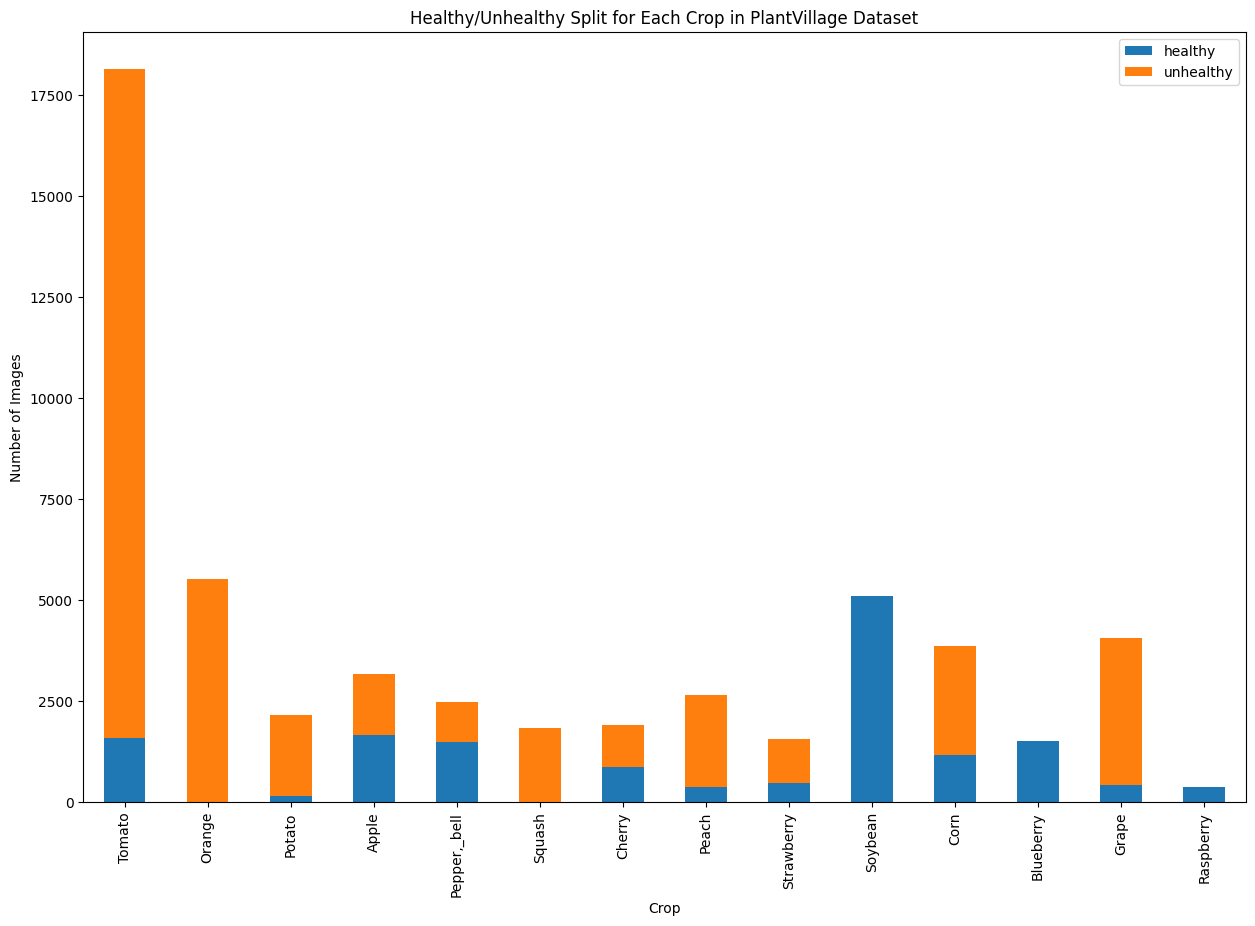

In [4]:
# Additional Summary healthy/unhealthy and Null

# Load the PlantVillage dataset
dataset, info = tfds.load('plant_village', with_info=True, as_supervised=True)

# Extract the dataset
dataset = dataset['train']

# Initialize counters and a dictionary to store class information
crop_health_counts = {}
total_images = 0
null_image_count = 0
null_label_count = 0

# Iterate through the dataset to count the occurrences of each class
for image, label in dataset:
    if image is None:
        null_image_count += 1
        continue
    if label is None:
        null_label_count += 1
        continue

    label_str = info.features['label'].int2str(label.numpy())
    crop_name, health_status = label_str.split("___")
    if crop_name not in crop_health_counts:
        crop_health_counts[crop_name] = {"healthy": 0, "unhealthy": 0}
    if health_status == "healthy":
        crop_health_counts[crop_name]["healthy"] += 1
    else:
        crop_health_counts[crop_name]["unhealthy"] += 1
    total_images += 1

# Convert the crop health counts to a DataFrame for better visualization
crop_health_counts_df = pd.DataFrame(crop_health_counts).T
crop_health_counts_df = crop_health_counts_df.reset_index().rename(columns={"index": "Crop"})
crop_health_counts_df["total"] = crop_health_counts_df["healthy"] + crop_health_counts_df["unhealthy"]

# Print summary information
print(f"Total number of images: {total_images}")
print(f"Total number of crops: {len(crop_health_counts)}")
print(f"Number of null images: {null_image_count}")
print(f"Number of null labels: {null_label_count}")
print("\nHealthy/Unhealthy split for each crop:\n")
print(crop_health_counts_df)

# Display the data as a bar plot
crop_health_counts_df.set_index('Crop')[['healthy', 'unhealthy']].plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Healthy/Unhealthy Split for Each Crop in PlantVillage Dataset')
plt.xlabel('Crop')
plt.ylabel('Number of Images')
plt.show()


In [5]:
# Load the PlantVillage dataset
dataset, info = tfds.load('plant_village', with_info=True, as_supervised=True)

# Extract the dataset
dataset = dataset['train']

# Initialize counters and a dictionary to store class information
crop_health_counts = {}
total_images = 0

# Iterate through the dataset to count the occurrences of each class
for image, label in dataset:
    label_str = info.features['label'].int2str(label.numpy())
    crop_name, health_status = label_str.split("___")
    if crop_name not in crop_health_counts:
        crop_health_counts[crop_name] = {"healthy": 0, "unhealthy": 0}
    if health_status == "healthy":
        crop_health_counts[crop_name]["healthy"] += 1
    else:
        crop_health_counts[crop_name]["unhealthy"] += 1
    total_images += 1

# Convert the crop health counts to a DataFrame for better visualization
crop_health_counts_df = pd.DataFrame(crop_health_counts).T
crop_health_counts_df = crop_health_counts_df.reset_index().rename(columns={"index": "Crop"})
crop_health_counts_df["total"] = crop_health_counts_df["healthy"] + crop_health_counts_df["unhealthy"]

# Create a nicely formatted table using tabulate
table = tabulate(crop_health_counts_df, headers='keys', tablefmt='grid')

# Print the formatted table
print(table)


+----+--------------+-----------+-------------+---------+
|    | Crop         |   healthy |   unhealthy |   total |
+====+==============+===========+=============+=========+
|  0 | Tomato       |      1591 |       16568 |   18159 |
+----+--------------+-----------+-------------+---------+
|  1 | Orange       |         0 |        5507 |    5507 |
+----+--------------+-----------+-------------+---------+
|  2 | Potato       |       152 |        2000 |    2152 |
+----+--------------+-----------+-------------+---------+
|  3 | Apple        |      1645 |        1526 |    3171 |
+----+--------------+-----------+-------------+---------+
|  4 | Pepper,_bell |      1477 |         997 |    2474 |
+----+--------------+-----------+-------------+---------+
|  5 | Squash       |         0 |        1835 |    1835 |
+----+--------------+-----------+-------------+---------+
|  6 | Cherry       |       854 |        1052 |    1906 |
+----+--------------+-----------+-------------+---------+
|  7 | Peach  

# Tomato Dataset

In [7]:
# Load the PlantVillage dataset
dataset, info = tfds.load('plant_village', with_info=True, as_supervised=True)

# Assuming 'train' is the correct split; adjust as necessary based on 'info.splits'
train_dataset = dataset['train']  # Correctly access the 'train' split if it exists

def preprocess_and_filter(image, label):
    # Resize and normalize the image
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0
    # Decode the label into a string
    label_str = info.features['label'].int2str(label.numpy())
    # Check if the label denotes a tomato
    is_tomato = tf.strings.regex_full_match(label_str, ".*Tomato.*")
    return is_tomato, image, label_str

def apply_preprocess_and_filter(image, label):
    return tf.py_function(preprocess_and_filter, [image, label], [tf.bool, tf.float32, tf.string])

def filter_tomato(is_tomato, image, label):
    return is_tomato

def map_to_image_label(is_tomato, image, label):
    return image, label

# Apply preprocessing and filtering to the dataset
processed_dataset = train_dataset.map(apply_preprocess_and_filter, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tomato_dataset = processed_dataset.filter(filter_tomato).map(map_to_image_label)


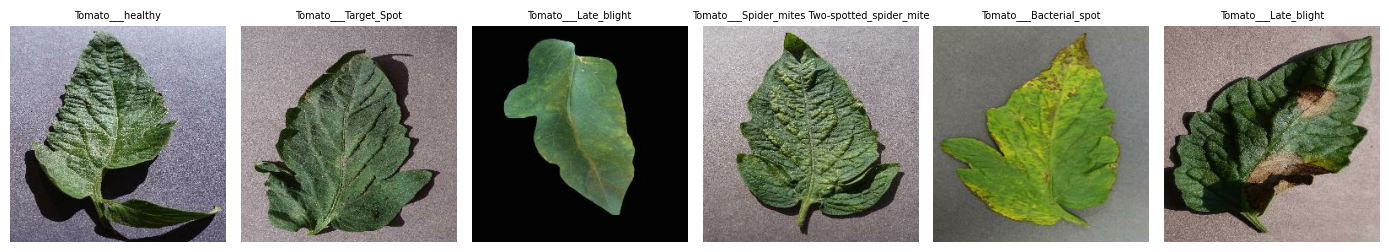

In [8]:
# Print Tomato images

# Collect examples
healthy_tomatoes = []
unhealthy_tomatoes = []

for image, label in tomato_dataset.take(10):
    label = label.numpy().decode('utf-8')
    if 'healthy' in label and len(healthy_tomatoes) < 5:
        healthy_tomatoes.append((image.numpy(), label))
    elif 'healthy' not in label and len(unhealthy_tomatoes) < 5:
        unhealthy_tomatoes.append((image.numpy(), label))

# Display the images
plt.figure(figsize=(14, 14))
for i, (image, label) in enumerate(healthy_tomatoes + unhealthy_tomatoes):
    ax = plt.subplot(2, 6, i + 1)
    plt.imshow(image)
    plt.title(label, fontsize = 7)
    plt.axis('off')
plt.tight_layout() # Ensure there is space for title
plt.show()


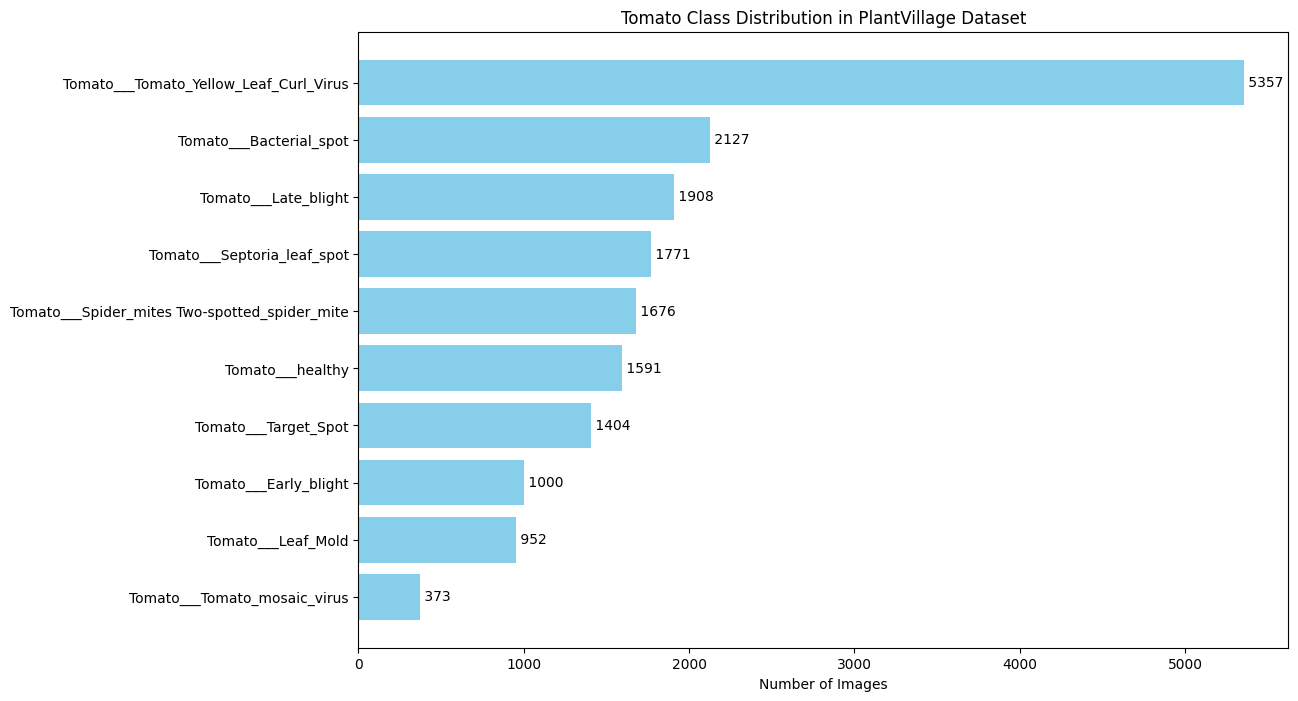

In [11]:
# Apply your preprocessing, filtering, and mapping functions
processed_dataset = dataset['train'].map(apply_preprocess_and_filter, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tomato_dataset = processed_dataset.filter(filter_tomato).map(map_to_image_label)

# Collect labels
labels = []

# Iterate through the tomato_dataset to collect labels
for image, label in tomato_dataset:
    labels.append(label.numpy().decode('utf-8'))

# Count the occurrences of each label
label_counts = Counter(labels)

# Data for plotting
classes = list(label_counts.keys())
counts = list(label_counts.values())

# Sort classes by counts (optional)
sorted_classes = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
classes, counts = zip(*sorted_classes)  # Unzip the sorted items

# Creating a horizontal bar chart for better readability
plt.figure(figsize=(12, 8))
bars = plt.barh(classes, counts, color='skyblue')  # Horizontal bar chart
plt.xlabel('Number of Images')
plt.title('Tomato Class Distribution in PlantVillage Dataset')

# Adding text labels to each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {count}', va='center')

plt.gca().invert_yaxis()  # Invert y-axis to have the highest counts at the top
plt.show()
